# Equivalent Source Layouts

We will try different source layouts for gridding harmonic data through the Equivalent Layer approach:

1. One source point beneath each data point
2. Block reduce the observation points and put one source point beneath the reduced coordinate for each block
3. Block reduce the observation points and put one source point beneath the center of each block
4. A regular grid of source points

Moreover, the depth of the sources can be chosen by different ways. Here we will try the following:

1. Put the source points at a constant relative depth from the data points. If the source points are block reduced, then the relative depth can be computed as the block reduced upward component from the observation points. If the source points are put on a regular grid, then the constant relative depth can be referenced to the mean upward coordinate of all data points.
2. Put the source points at an adaptive depth: define it as a quantity proportional to the mean (or median) distance to the k nearest source points. Also, this depth can be static shifted by a constant depth in order to avoid very shallow sources in case of too close source points.

Here we will show some examples on how each source layout look like for the same data set.


**Import useful packages**

In [1]:
import pyproj
import numpy as np
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt

from eql_source_layouts import adaptive_depth, block_reduce_points

**Define parameters for building the source layouts**

In [2]:
# Set the region where the data is going to be reduced
region_deg = [-42.35, -42.10, -22.35, -22.15]  # given in degrees

# Set a constant relative depth of 1km
relative_depth = 1000

# Set default parameters for block reducing the data
block_reduction_params = {
    "spacing": 1000,  # set a block size of 1km
}

# Set default parameters for adaptive depth
# For one source beneath each data point
adaptive_params = {"depth_factor": 0.5, "depth_shift": -500, "k_nearest": 15}
# For block reduced points
adaptive_params_reduced = {"depth_factor": 0.2, "depth_shift": -500, "k_nearest": 2}

**Define function to plot multiple layouts**

In [3]:
def plot_layouts(layouts, s=40):
    """
    Plot multiple source layouts as scatter points sharing colorbar
    """
    elevations = tuple(p[2] for p in layouts.values())
    vmin = np.min([e.min() for e in elevations])
    vmax = np.max([e.max() for e in elevations])
    
    n_plots = len(layouts)
    fig, axes = plt.subplots(
        figsize=(6, 4 * n_plots),
        nrows=n_plots,
        ncols=1,
        sharex=True,
        sharey=True,
    )
    for ax, layout in zip(axes, layouts):
        points = layouts[layout]
        tmp = ax.scatter(*points[:2], c=points[2], s=s, vmin=vmin, vmax=vmax)
        ax.set_title("{} (n_points: {})".format(layout, points[0].size))
        ax.set_aspect("equal")
        plt.colorbar(tmp, ax=ax, label="m")
    plt.tight_layout()
    plt.show()

# Fetch Rio de Janeiro airborne magnetic data

In [4]:
data = hm.datasets.fetch_rio_magnetic()

Slice a smaller portion of the survey data to speed-up calculations for this notebook

In [5]:
inside = vd.inside((data.longitude, data.latitude), region_deg)
data = data[inside]
print("Number of data points:", data.shape[0])

Number of data points: 6251


Since this is a small area, we'll project our data and use Cartesian coordinates

In [6]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data["easting"], data["northing"] = projection(
    data.longitude.values, data.latitude.values
)

Define coordinates tuple and the projected region

In [7]:
coordinates = (data.easting, data.northing, data.altitude_m)
region = vd.get_region(coordinates)

Plot the observed magnetic data

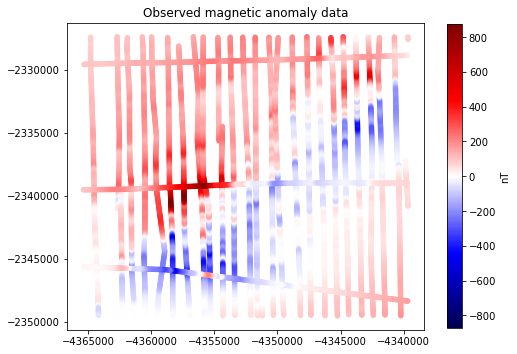

In [8]:
maxabs = vd.maxabs(data.total_field_anomaly_nt)

fig, ax = plt.subplots(figsize=(8, 8))
tmp = ax.scatter(
    data.easting,
    data.northing,
    c=data.total_field_anomaly_nt,
    s=20,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
ax.set_title("Observed magnetic anomaly data")
ax.set_aspect("equal")
plt.colorbar(tmp, ax=ax, label="nT", shrink=0.7)
plt.show()

# Build source layouts for constant relative depth

Let's define two dictionaries where all the source layouts are going to be stored

In [9]:
constant_depth_layouts = {}
adaptive_depth_layouts = {}

And add the region to the ``block_reduced_params`` dictionary:

In [10]:
block_reduction_params["region"] = region

## One source beneath each data point

Let's put one source point beneath each data point at a constant relative depth from the elevation of the data point:

In [11]:
points = tuple(i.ravel() for i in coordinates)
points = (
    points[0],
    points[1],
    points[2] - relative_depth
)
constant_depth_layouts["source_beneath_data"] = points

## One source beneath the block reduced data points

Let's put one source point beneath the block reduced data points at a constant relative depth from the reduced elevation of the data points: 

In [12]:
points = block_reduce_points(coordinates, **block_reduction_params)
points = (
    points[0],
    points[1],
    points[2] - relative_depth
)
constant_depth_layouts["block_reduced"] = points

## One source beneath the center of  the blocks

Let's block reduce the data points and put one source point beneath the center of each populated block at a constant relative depth from the reduced elevation of the data points: 

In [13]:
points = block_reduce_points(
    coordinates, center_coordinates=True, **block_reduction_params
)
points = (
    points[0],
    points[1],
    points[2] - relative_depth
)
constant_depth_layouts["block_reduced_on_center"] = points

## Regular grid of source points

Let's create a regular grid of source points located at a constant relative depth under the mean elevation of data points. This can easily be done by block splitting the region of the data points and putting one source point beneath each block (considering every block, not just the ones that are populated).

In [14]:
(easting, northing), _ = vd.block_split(
    coordinates, **block_reduction_params
)
upward = (
    np.full_like(easting, np.mean(coordinates[2]))
    - relative_depth
)
points = (easting, northing, upward)
constant_depth_layouts["grid"] = points

# Plot sources layouts with constant relative depth

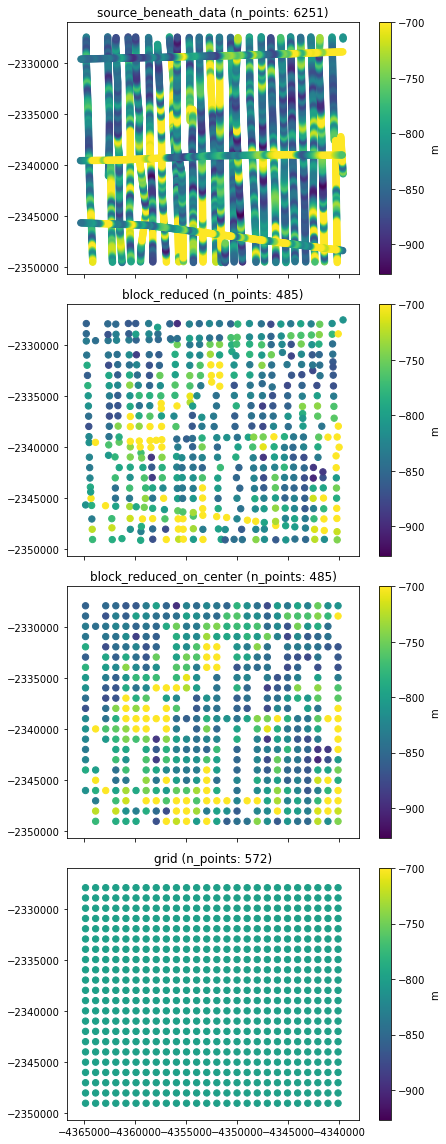

In [15]:
plot_layouts(constant_depth_layouts)

# Build source layouts for adaptive depth

## One source beneath each data point

Let's put one source point beneath each data point at an adaptive depth based on the k nearest neighbours points:

In [16]:
points = tuple(i.ravel() for i in coordinates)
points = adaptive_depth(points, **adaptive_params)
adaptive_depth_layouts["source_beneath_data"] = points

## One source beneath the block reduced data points

Let's put one source point beneath the block reduced data points at  an adaptive depth based on the k nearest neighbours points:

In [17]:
points = block_reduce_points(coordinates, **block_reduction_params)
points = adaptive_depth(points, **adaptive_params_reduced)
adaptive_depth_layouts["block_reduced"] = points

## One source beneath the center of  the blocks

Let's block reduce the data points and put one source point beneath the center of each populated block at  an adaptive depth based on the k nearest neighbours points:

In [18]:
points = block_reduce_points(
    coordinates, center_coordinates=True, **block_reduction_params
)
points = adaptive_depth(points, **adaptive_params_reduced)
adaptive_depth_layouts["block_reduced_on_center"] = points

# Plot sources layouts with adaptive depth

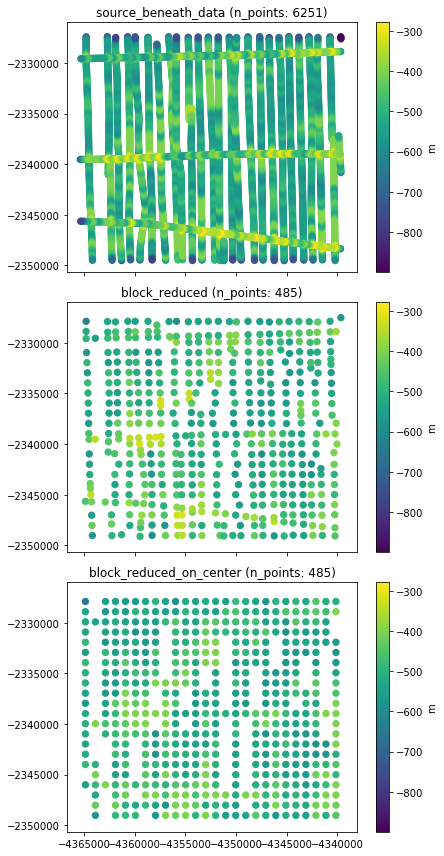

In [19]:
plot_layouts(adaptive_depth_layouts)